In [1]:
from __future__ import print_function
%matplotlib inline 
# make plots show in ipython notebook

from gensim import models, matutils, utils
import numpy as np
import os, sys
import logging
import nltk
from nltk.corpus import stopwords
import random
import pandas as pd
import pylab
import itertools
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# Get logging information

In [2]:
# Initialize global variables
doc_vec = None
query_vec = None
vectorizer = None
tfidf = None # TF-IDF model
tokens_list = None # List of tokens used by TF-IDF

In [3]:
# Load pre-trained representation model. Whether load those model at the same time depends on the space of your RAM

# Load pre-trained word2vec model from disk
word2vec_model = models.word2vec.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True) 
#word2vec_model = models.word2vec.Word2Vec.load_word2vec_format('glove.6B.100d.word2vec.txt', binary = False)

# word2vec_model.vocab: 3000000  words for word2vec_model.
# each word are represented as a vector with 300 terms
# word2vec_model.syn0: matrix for the model
# word2vec_model.syn0.shape: check the shape of this matrix
# Normalize all vectors in this model. 
# So we can use dot product to calculate cosine similarity which is more efficient
word2vec_model.init_sims(replace = True)
# The normalized vectors are stored in model.syn0 and model.syn0norm. These are the same.

INFO:gensim.models.word2vec:loading projection weights from GoogleNews-vectors-negative300.bin
INFO:gensim.models.word2vec:loaded (3000000L, 300L) matrix from GoogleNews-vectors-negative300.bin
INFO:gensim.models.word2vec:precomputing L2-norms of word weight vectors


In [4]:
# Load two files
target_file = pd.read_table("target_collection", compression = None, header = 0, sep = '\t')
logger.info(("target file loaded. " + str(np.shape(target_file)[0]) + " documents."))
query_file = pd.read_table("queries_val", compression = None, header = 0, sep = '\t')
logger.info(("query file loaded. " + str(np.shape(query_file)[0]) + " queries."))

INFO:root:target file loaded. 17784 documents.
INFO:root:query file loaded. 1000 queries.


In [5]:
def tokenize(text):
    """split texts into tokens and remove dot and comma"""
    tokens0 = nltk.word_tokenize(text)
    tokens = [t for t in tokens0 if t not in [',', '.']]
    return tokens

In [6]:
def initializeMatrix(text_file):
    """transform docs into vectors"""
    text_vec = []
    for row in text_file.itertuples():
        tokensForDoc = tokenize(row[3])
        sum_word_vec = sum(word2vec_model[tok] for tok in tokensForDoc if tok in word2vec_model.vocab)
        text_vec.append(matutils.unitvec(sum_word_vec)) # normalize each sum vector
    return np.array(text_vec)

In [7]:
# It takes long time. be patient
doc_vec = initializeMatrix(target_file)
query_vec = initializeMatrix(query_file)

In [8]:
# compute the inner product (cosine similarity) for all queries and targets
similarity_matrix = np.dot(query_vec, doc_vec.T)

In [9]:
def getAveragePrecision(query_img_id, best, cutoff):
    """compute AP for each query"""
    tp_series = np.where(np.asarray([target_file['img_id'][x] for x in best[:cutoff]]) == query_img_id)[0]
    tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
    tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn
    averPrec = sum(tp_tpfp)/tpfn
    return averPrec

In [10]:
def precAndRec(query_img_id, best):
    """compute precision-recall for each query"""
    tp_series = np.where(np.array([target_file['img_id'][x] for x in best]) == query_img_id)[0]
    tp_tpfp = [(i_no + 1.0)/(i + 1.0) for i_no, i in enumerate(tp_series)]# precision = (tp/(tp+fp))
    tpfn = len(np.where(target_file['img_id'] == query_img_id)[0]) #tp+fn
    tmp = 0
    precRecall_arr = [0.0] * 11
    i= 0
    for tmp in range(len(tp_tpfp)):
            while (i/10.0) <= ((tmp + 1.0) / tpfn):
                precRecall_arr[i] = tp_tpfp[tmp]
                i += 1
    return np.array(precRecall_arr)

In [11]:
def meanResult(similarity_matrix, model_name):
    """compute average AP and precision-recall for all queries"""
    sum_averagePrecision = []
    sum_precision = np.array([0.0] * 11)
    for row in query_file.itertuples():
        query_index, query_img_id = row[0], row[2]
        best = np.argsort(-(similarity_matrix[query_index])) # sort all similarity scores decreasingly
        sum_averagePrecision.append(getAveragePrecision(query_img_id, best, 1000))
        prec = precAndRec(query_img_id, best)
        sum_precision += prec
        
    meanAP = sum(sum_averagePrecision) / 1000
    print("Mean Average Precision of " + model_name + " is: ", str(meanAP))
    pylab.plot(np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), sum_precision / 1000)
    pylab.xlabel('recall')
    pylab.ylabel('precision')
    pylab.title(model_name)

Mean Average Precision of Addictive Vector-based Model is:  0.173808861412


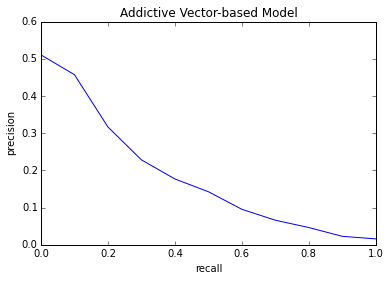

In [12]:
meanResult(similarity_matrix, "Addictive Vector-based Model") # it takes long time, be patient

In [9]:
def searchPairs(outFileName, similarity_matrix):
    outFile = open(outFileName, 'w')
    for row in query_file.itertuples():
        query_index, query_img_id, query = row[0], row[2], row[3]
        best = np.argsort(-(similarity_matrix[query_index]))
        best = best[:1000]
        if len(best) > 0:
            target_doc = target_file['txt_caption'][best]
            target_key = target_file['img_id'][best]
            d = {'query': [query]*1000, 'target': target_doc, 'match': [query_img_id]*1000 == target_key, 'score':similarity_matrix[query_index][best]}
            d = pd.DataFrame(d)
            for row1 in d.itertuples():
                toWrite = str(row1[1]) + '\t' + row1[2] + '\t' + row1[4] + '\t' + str(row1[3]) + '\n'
                outFile.write(toWrite)
    outFile.close() 

In [35]:
searchPairs('additionalModelResult.txt', similarity_matrix) # if you want to save the result of all 1000 ranks, run this line

In [13]:
# delete these objects to save space
del similarity_matrix
del doc_vec
del query_vec

In [14]:
def getTFIDF():
    """Return cached TFIDF model."""
    global vectorizer
    global tokens_list
    global tfidf
    
    if tfidf is None:
        vectorizer = CountVectorizer(tokenizer=tokenize, stop_words=stopwords.words('english'), lowercase=False)
        texts_counts = vectorizer.fit_transform(target_file['txt_caption'])
        tokens_list = vectorizer.get_feature_names()
        tfidf = TfidfTransformer()
        texts_weights = tfidf.fit_transform(texts_counts)
    return tfidf

In [15]:
def initializeMatrixTFIDF(text_file):
    """transform docs into TFIDF weighted metrics"""
    tfidf = getTFIDF()
    text_vec = []
    dic0 = {}
    for row in text_file.itertuples():
        tokensForDoc = tokenize(row[3])
        text_weight = tfidf.transform(vectorizer.transform([row[3]]))
        # get TFIDF weights for all non-zero tokens
        for i in text_weight.nonzero()[1]:
            dic0[tokens_list[i]] = text_weight[0, i]
            
        sum_word_vec = sum(word2vec_model[tok]*dic0[tok] for tok in tokensForDoc if (tok in dic0.keys()) and(tok in word2vec_model.vocab))
        if type(sum_word_vec) == type(0): 
            # it is possible that query share no common word except stop words with any document
            # in this case, the sum_word_vec will be zero instead of an array of zero. An array is needed to avoid error from inner product.
            sum_word_vec = [0]*300
            text_vec.append(sum_word_vec)
        else:
            text_vec.append(matutils.unitvec(sum_word_vec)) # normalize each sum vector
    return np.array(text_vec)

In [16]:
# takes long time, be patient
doc_vec_tfidf = initializeMatrixTFIDF(target_file)
query_vec_tfidf = initializeMatrixTFIDF(query_file)

F:\Program Files\Anaconda\lib\site-packages\IPython\kernel\__main__.py:11: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [17]:
# compute the inner product (cosine similarity) for all queries and targets
similarity_matrix_tfidf = np.dot(query_vec_tfidf, doc_vec_tfidf.T)

Mean Average Precision of Modified addictive model is:  0.247288920565


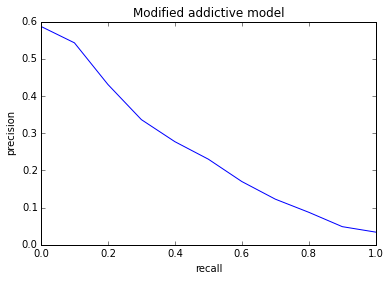

In [18]:
meanResult(similarity_matrix_tfidf, "Modified addictive model") # takes long time, be patient

In [43]:
searchPairs('modifiedAdditionalModelResult.txt', similarity_matrix_tfidf)

In [19]:
test_index = [0, 2, 3]
test_queries = ["Two people in a group of four are holding awards as they pose for a picture.",\
                "A woman in a red dress is posing with an axe.",\
                "Two soccer plays stand next to each other with soccer balls in front of them."]
test_keys = ["CbnA_e6AW6U7Ycoa", "PaqtOaYmQmXkqW2i", "IPcFtNL-7EQ6Z0yu"]

In [20]:
def testExamples(query_index, query, key, similarity_matrix):
    best = np.argsort(-(similarity_matrix[query_index]))
    target_doc = target_file['txt_caption'][best[:1000]]
    target_key = target_file['img_id'][best[:1000]]
    d = {'target':target_doc, 'match':[key]*1000 == target_key, 'score':similarity_matrix[query_index][best[:1000]]}
    d = pd.DataFrame(d)
    for i in range(20):
        print(d['match'].iloc[i])
        print(d['score'].iloc[i])
        print(query)
        print(d['target'].iloc[i])
        print()
    return d

In [21]:
test1 = testExamples(test_index[0], test_queries[0], test_keys[0], similarity_matrix_tfidf)

False
0.788383126777
Two people in a group of four are holding awards as they pose for a picture.
Seven ladies and one man, standing in a row, in front of a picture, posing with awards in their hands.

False
0.787375317174
Two people in a group of four are holding awards as they pose for a picture.
A group of people holding a bunch of different awards.

True
0.785077743848
Two people in a group of four are holding awards as they pose for a picture.
A group of people are standing together and holding awards.

False
0.781540679274
Two people in a group of four are holding awards as they pose for a picture.
Three people posing for a picture holding a trophy.

False
0.77448716046
Two people in a group of four are holding awards as they pose for a picture.
There is a group of women holding awards standing next to a man.

False
0.761912518923
Two people in a group of four are holding awards as they pose for a picture.
A group of four people posing for a photo.

False
0.754153146261
Two peopl

In [22]:
test2 = testExamples(test_index[1], test_queries[1], test_keys[1], similarity_matrix_tfidf)

False
0.942227125316
A woman in a red dress is posing with an axe.
A woman posing in a white dress.

False
0.931961611256
A woman in a red dress is posing with an axe.
A woman posing in a pink dress.

False
0.921175515376
A woman in a red dress is posing with an axe.
A woman wearing a pink dress is posing.

False
0.90338004972
A woman in a red dress is posing with an axe.
A woman posing in a red gown.

False
0.901263774289
A woman in a red dress is posing with an axe.
A red haired woman in a dress is posing.

False
0.885572941052
A woman in a red dress is posing with an axe.
A girl is standing posing in a pink dress.

False
0.882335591686
A woman in a red dress is posing with an axe.
A woman in a pink dress posing for the photo.

False
0.880408266323
A woman in a red dress is posing with an axe.
A blonde woman posing in a black and white dress.

False
0.875129225352
A woman in a red dress is posing with an axe.
A picture of a woman in a red dress posing for the camera.

False
0.8701230

In [23]:
test3 = testExamples(test_index[2], test_queries[2], test_keys[2], similarity_matrix_tfidf)

False
0.895270655153
Two soccer plays stand next to each other with soccer balls in front of them.
A soccer player in a green uniform during soccer match dribbling the ball.

False
0.885047183757
Two soccer plays stand next to each other with soccer balls in front of them.
An airborne soccer player that has just head-butted the soccer ball.

False
0.870058646465
Two soccer plays stand next to each other with soccer balls in front of them.
A group of soccer players in white uniforms on a soccer field walking away from the camera.

True
0.840832772947
Two soccer plays stand next to each other with soccer balls in front of them.
Two men are standing with soccer balls.

False
0.833943727614
Two soccer plays stand next to each other with soccer balls in front of them.
Two men play soccer inside.

False
0.828520449397
Two soccer plays stand next to each other with soccer balls in front of them.
Two people playing a game of soccer.

False
0.823731999872
Two soccer plays stand next to each oth